In [57]:
import sys
import time
from urllib.error import URLError 
from http.client import BadStatusLine 
import json
import twitter
import pandas as pd
import numpy as np
import scipy.stats as st
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from statsmodels.tsa import stattools as tsa
import datetime
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from hmmlearn import hmm

In [2]:
def norm(series):
    b = max(series)
    a = min(series)
    return [(x - a) / (b - a) for x in series]

In [3]:
def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
    # for more information on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'vbxvd6AcBc5DD9bQx0AKYrwo0' 
    CONSUMER_SECRET = 'Aok2PL4En5501TzwR0r4rF3M1OBqsUB4GWbGRFdnC6bkUQYY1l' 
    OAUTH_TOKEN = '1450351904664571906-hCxwI60DC4dxJVDe2DtQMQdC8xe8iy'
    OAUTH_TOKEN_SECRET = 'CzQ7jgkpMNpmD3WOsRndcNNc6o2kPl2lOGGdf0sH9APdP'

    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print(twitter_api)

In [4]:
# The Yahoo! Where On Earth ID for the entire world is 1. # See http://bit.ly/2BGWJBU and
# http://bit.ly/2MsvwCQ
WORLD_WOE_ID = 1 
US_WOE_ID = 23424977
# Prefix ID with the underscore for query string parameterization. # Without the underscore, the twitter package appends the ID value # to the URL itself as a special case keyword argument.
world_trends = twitter_api.trends.place(_id=WORLD_WOE_ID) 
us_trends = twitter_api.trends.place(_id=US_WOE_ID)
print(world_trends)
print()
print(us_trends)

[{'trends': [{'name': '#DIADEFURIA', 'url': 'http://twitter.com/search?q=%23DIADEFURIA', 'promoted_content': None, 'query': '%23DIADEFURIA', 'tweet_volume': 52524}, {'name': '#الشباب_النصر', 'url': 'http://twitter.com/search?q=%23%D8%A7%D9%84%D8%B4%D8%A8%D8%A7%D8%A8_%D8%A7%D9%84%D9%86%D8%B5%D8%B1', 'promoted_content': None, 'query': '%23%D8%A7%D9%84%D8%B4%D8%A8%D8%A7%D8%A8_%D8%A7%D9%84%D9%86%D8%B5%D8%B1', 'tweet_volume': 89122}, {'name': '#INDvsSCO', 'url': 'http://twitter.com/search?q=%23INDvsSCO', 'promoted_content': None, 'query': '%23INDvsSCO', 'tweet_volume': 38900}, {'name': '#ThankYouBrandon', 'url': 'http://twitter.com/search?q=%23ThankYouBrandon', 'promoted_content': None, 'query': '%23ThankYouBrandon', 'tweet_volume': 34268}, {'name': '#SJ_16th_ANNIVERSARY', 'url': 'http://twitter.com/search?q=%23SJ_16th_ANNIVERSARY', 'promoted_content': None, 'query': '%23SJ_16th_ANNIVERSARY', 'tweet_volume': 102645}, {'name': 'Lütfü Türkkan', 'url': 'http://twitter.com/search?q=%22L%C3%BCtf

In [5]:
import json
print(json.dumps(world_trends, indent=1)) 
print()
print(json.dumps(us_trends, indent=1))

[
 {
  "trends": [
   {
    "name": "#DIADEFURIA",
    "url": "http://twitter.com/search?q=%23DIADEFURIA",
    "promoted_content": null,
    "query": "%23DIADEFURIA",
    "tweet_volume": 52524
   },
   {
    "name": "#\u0627\u0644\u0634\u0628\u0627\u0628_\u0627\u0644\u0646\u0635\u0631",
    "url": "http://twitter.com/search?q=%23%D8%A7%D9%84%D8%B4%D8%A8%D8%A7%D8%A8_%D8%A7%D9%84%D9%86%D8%B5%D8%B1",
    "promoted_content": null,
    "query": "%23%D8%A7%D9%84%D8%B4%D8%A8%D8%A7%D8%A8_%D8%A7%D9%84%D9%86%D8%B5%D8%B1",
    "tweet_volume": 89122
   },
   {
    "name": "#INDvsSCO",
    "url": "http://twitter.com/search?q=%23INDvsSCO",
    "promoted_content": null,
    "query": "%23INDvsSCO",
    "tweet_volume": 38900
   },
   {
    "name": "#ThankYouBrandon",
    "url": "http://twitter.com/search?q=%23ThankYouBrandon",
    "promoted_content": null,
    "query": "%23ThankYouBrandon",
    "tweet_volume": 34268
   },
   {
    "name": "#SJ_16th_ANNIVERSARY",
    "url": "http://twitter.com/search?q=

In [6]:
world_trends_set = set([trend['name']
for trend in world_trends[0]['trends']])
us_trends_set = set([trend['name']
for trend in us_trends[0]['trends']])
common_trends = world_trends_set.intersection(us_trends_set) 
print(common_trends)

{'Summer Walker', 'Xavi', 'Guy Fawkes', 'SADIE', 'Browns', 'Bloody Wolf', 'Colin Powell', 'Raiders', 'Ciara', '5th of November', 'ABBA', '#advyout', 'Joe Rogan', 'dylan', 'Odell', 'Kanye', '#ThankYouBrandon', 'Pfizer', 'Aaron Rodgers', 'Deron Williams', 'taylor', 'Frank Gore'}


In [98]:
# Set this variable to a trending topic, or anything else # for that matter. The example query below was a
# trending topic when this content was being developed
# and is used throughout the remainder of this chapter.
q = 'Tesla' 
count = 100000
# Import unquote to prevent URL encoding errors in next_results
from urllib.parse import unquote
# See https://dev.twitter.com/rest/reference/get/search/tweets 
search_results = twitter_api.search.tweets(q=q, count=count) 
statuses = search_results['statuses']
# Iterate through 5 more batches of results by following the cursor
for _ in range(5):
    #print('Length of statuses', len(statuses)) 
    try:
        next_results = search_results['search_metadata']['next_results']
    except KeyError as e: # No more results when next_results doesn't
        break
    kwargs = dict([ kv.split('=') for kv in unquote(next_results[1:]). split("&") ])
    search_results = twitter_api.search.tweets(**kwargs) 
    statuses += search_results['statuses']
    # Show one sample search result by slicing the list...
    #print(json.dumps(statuses[0], indent=1))
len(statuses)

563

In [84]:
status_texts = [ status['text']
for status in statuses ]
screen_names = [ user_mention['screen_name'] for status in statuses
for user_mention in status['entities']['user_mentions'] ]
hashtags = [ hashtag['text']
for status in statuses
for hashtag in status['entities']['hashtags'] ]
# Compute a collection of all words from all tweets
words = [ w
for t in status_texts
for w in t.split() ]
# Explore the first 5 items for each...
print(json.dumps(status_texts[0:5], indent=1)) 
print(json.dumps(screen_names[0:5], indent=1)) 
print(json.dumps(hashtags[0:5], indent=1)) 
print(json.dumps(words[0:5], indent=1))

[
 "RT @elonmusk: @DrEliDavid If WFP can describe on this Twitter thread exactly how $6B will solve world hunger, I will sell Tesla stock right\u2026",
 "RT @DogeFamily4: @elonmusk When you will announce tesla accept doge ?",
 "@realMeetKevin @elonmusk Musk gonna crush the Tesla again",
 "RT @Tesla: Happy Halloween \ud83c\udf83 https://t.co/d5ijx1PDjW",
 "@Investments_CEO @elonmusk @Tesla #Musk killed #dogecoin when he appeared on SNL, no way on earth he would accept a\u2026 https://t.co/OO2ueNXQpF"
]
[
 "elonmusk",
 "DrEliDavid",
 "DogeFamily4",
 "elonmusk",
 "realMeetKevin"
]
[
 "Musk",
 "dogecoin",
 "Dogecoin",
 "Marscoin",
 "MarscoinArmy"
]
[
 "RT",
 "@elonmusk:",
 "@DrEliDavid",
 "If",
 "WFP"
]


In [85]:
from collections import Counter
for item in [words, screen_names, hashtags]: 
    c = Counter(item) 
    print(c.most_common()[:10]) # top 10 
    print()

[('of', 814), ('Tesla', 424), ('RT', 392), ('a', 307), ('is', 291), ('10%', 264), ('I', 252), ('you', 238), ('so', 223), ('my', 223)]

[('elonmusk', 345), ('MrBeast', 37), ('Tesla', 36), ('MattWallace888', 11), ('business', 9), ('EylemCulculoglu', 7), ('CNBC', 7), ('TESLA_CREADOR', 7), ('engineers_feed', 7), ('WholeMarsBlog', 6)]

[('Dogecoin', 15), ('Tesla', 10), ('tesla', 5), ('dogecoin', 4), ('TSLA', 4), ('BLASTfriday', 4), ('winner', 4), ('ElonMusk', 3), ('Featured', 3), ('SafeBLAST', 3)]



In [86]:
from prettytable import PrettyTable
for label, data in (('Word', words),
('Screen Name', screen_names),
('Hashtag', hashtags)):
    pt = PrettyTable(field_names=[label, 'Count'])
    c = Counter(data)
    [ pt.add_row(kv) for kv in c.most_common()[:10] ]
    pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment
    print(pt)

+-------+-------+
| Word  | Count |
+-------+-------+
| of    |   814 |
| Tesla |   424 |
| RT    |   392 |
| a     |   307 |
| is    |   291 |
| 10%   |   264 |
| I     |   252 |
| you   |   238 |
| so    |   223 |
| my    |   223 |
+-------+-------+
+-----------------+-------+
| Screen Name     | Count |
+-----------------+-------+
| elonmusk        |   345 |
| MrBeast         |    37 |
| Tesla           |    36 |
| MattWallace888  |    11 |
| business        |     9 |
| EylemCulculoglu |     7 |
| CNBC            |     7 |
| TESLA_CREADOR   |     7 |
| engineers_feed  |     7 |
| WholeMarsBlog   |     6 |
+-----------------+-------+
+-------------+-------+
| Hashtag     | Count |
+-------------+-------+
| Dogecoin    |    15 |
| Tesla       |    10 |
| tesla       |     5 |
| dogecoin    |     4 |
| TSLA        |     4 |
| BLASTfriday |     4 |
| winner      |     4 |
| ElonMusk    |     3 |
| Featured    |     3 |
| SafeBLAST   |     3 |
+-------------+-------+


In [87]:
# A function for computing lexical diversity
def lexical_diversity(tokens):
    return len(set(tokens))/len(tokens)
# A function for computing the average number of words per tweet
def average_words(statuses):
    total_words = sum([ len(s.split()) for s in statuses ]) 
    return total_words/len(statuses)
print(lexical_diversity(words))
print(lexical_diversity(screen_names))
print(lexical_diversity(hashtags))
print(average_words(status_texts))

0.18331076506431956
0.28067885117493474
0.4329896907216495
20.585365853658537


In [88]:
retweets = [
    # Store out a tuple of these three values...
    (status['retweet_count'], status['retweeted_status']['user']['screen_name'], status['text'])
    # ... for each status...
    for status in statuses
    # ... so long as the status meets this condition
    if 'retweeted_status' in status.keys() 
]

pt = PrettyTable(field_names=['Count', 'Screen Name', 'Text'])
[ pt.add_row(row) for row in sorted(retweets, reverse=True)[0:5] ] 
pt.max_width['Text'] = 50
pt.align= 'l'
print(pt)

+-------+-------------+----------------------------------------------------+
| Count | Screen Name | Text                                               |
+-------+-------------+----------------------------------------------------+
| 60930 | elonmusk    | RT @elonmusk: @DrEliDavid If WFP can describe on   |
|       |             | this Twitter thread exactly how $6B will solve     |
|       |             | world hunger, I will sell Tesla stock right…       |
| 60930 | elonmusk    | RT @elonmusk: @DrEliDavid If WFP can describe on   |
|       |             | this Twitter thread exactly how $6B will solve     |
|       |             | world hunger, I will sell Tesla stock right…       |
| 16998 | Jon4Lakers  | RT @Jon4Lakers: This is beyond wild. 🤯 @Tesla      |
|       |             | @elonmusk https://t.co/kUnqVb4aBq                  |
| 6087  | elonmusk    | RT @elonmusk: Trial program for opening Tesla      |
|       |             | Superchargers to other EVs has begun               |

Text(0.5, 0, 'Word Rank')

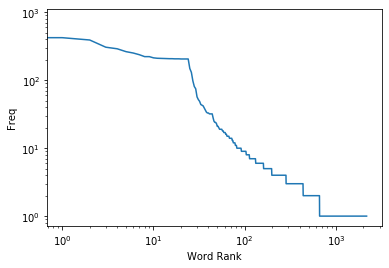

In [89]:
import matplotlib.pyplot as plt 
%matplotlib inline
word_counts = sorted(Counter(words).values(), reverse=True)
plt.loglog(word_counts) 
plt.ylabel("Freq") 
plt.xlabel("Word Rank")

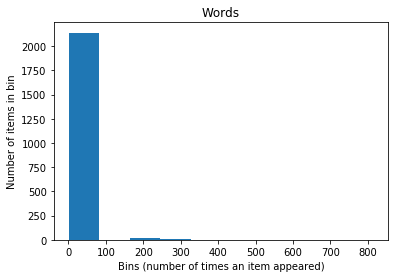

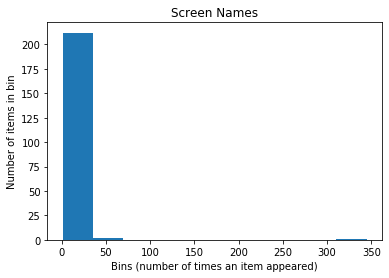

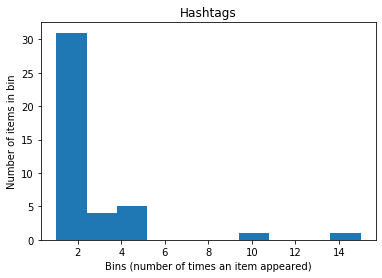

<Figure size 432x288 with 0 Axes>

In [90]:
for label, data in (('Words', words),('Screen Names', screen_names),('Hashtags', hashtags)):
# Build a frequency map for each set of data # and plot the values
    c = Counter(data)
    plt.hist(c.values())
    # Add a title and ylabel...
    plt.title(label)
    plt.ylabel("Number of items in bin")
    plt.xlabel("Bins (number of times an item appeared)")
    # ... and display as a new figure
    plt.figure()

Text(0, 0.5, 'Number of tweets in bin')

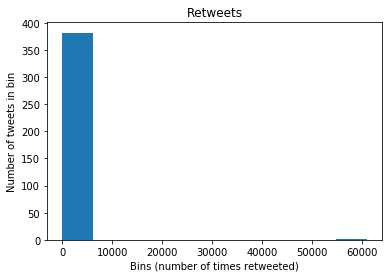

In [76]:
# Using underscores while unpacking values in # a tuple is idiomatic for discarding them
counts = [count for count, _, _ in retweets]
plt.hist(counts)
plt.title("Retweets")
plt.xlabel('Bins (number of times retweeted)') 
plt.ylabel('Number of tweets in bin')
#print(counts)

In [16]:
def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600:
            print('Too many retries. Quitting.', file=sys.stderr) 
            raise e
        if e.e.code == 401:
            print('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr) 
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys)
                return 2
            else:
                raise e
        elif e.e.code in (500,502,503,504):
            print('Encountered {0} Error. Retrying in {1} seconds'.format(e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period) 
            wait_period *= 1.5 
            return wait_period
        else:
            raise e
    wait_period = 2 
    error_count = 0
    while True: 
        try:
            return twitter_api_func(*args, **kw) 
        except twitter.api.TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period) 
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print("URLError encountered. Continuing.", file=sys.stderr) 
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e: 
            error_count += 1
        time.sleep(wait_period)
        wait_period *= 1.5
        print("BadStatusLine encountered. Continuing.", file=sys.stderr)
        if error_count > max_errors:
            print("Too many consecutive errors...bailing out.", file=sys.stderr)
            raise
#twitter_api = oauth_login()
# See http://bit.ly/2Gcjfzr for twitter_api.users.lookup
response = make_twitter_request(twitter_api.users.lookup, screen_name="SocialWebMining")
print(json.dumps(response, indent=1))

[
 {
  "id": 132373965,
  "id_str": "132373965",
  "name": "MiningTheSocialWeb",
  "screen_name": "SocialWebMining",
  "location": "",
  "description": "Get the source code at GitHub: http://t.co/U0VmWrXpB9",
  "url": "http://t.co/CJfJDyM6ki",
  "entities": {
   "url": {
    "urls": [
     {
      "url": "http://t.co/CJfJDyM6ki",
      "expanded_url": "http://miningthesocialweb.com",
      "display_url": "miningthesocialweb.com",
      "indices": [
       0,
       22
      ]
     }
    ]
   },
   "description": {
    "urls": [
     {
      "url": "http://t.co/U0VmWrXpB9",
      "expanded_url": "http://bit.ly/MiningTheSocialWeb2E",
      "display_url": "bit.ly/MiningTheSocia\u2026",
      "indices": [
       31,
       53
      ]
     }
    ]
   }
  },
  "protected": false,
  "followers_count": 4243,
  "friends_count": 0,
  "listed_count": 205,
  "created_at": "Tue Apr 13 02:10:40 +0000 2010",
  "favourites_count": 33,
  "utc_offset": null,
  "time_zone": null,
  "geo_enabled": false,


In [17]:
def harvest_user_timeline(twitter_api, screen_name=None, user_id=None, max_results=1000):
     
    assert (screen_name != None) != (user_id != None), "Must have screen_name or user_id, but not both"    
    
    kw = {  # Keyword args for the Twitter API call
        'count': 200,
        'trim_user': 'true',
        'include_rts' : 'true',
        'since_id' : 1
        }
    
    if screen_name:
        kw['screen_name'] = screen_name
    else:
        kw['user_id'] = user_id
        
    max_pages = 16
    results = []
    
    tweets = make_twitter_request(twitter_api.statuses.user_timeline, **kw)
    
    if tweets is None: # 401 (Not Authorized) - Need to bail out on loop entry
        tweets = []
        
    results += tweets
    
    #print('Fetched {0} tweets'.format(len(tweets)), file=sys.stderr)
    
    page_num = 1
    
    # Many Twitter accounts have fewer than 200 tweets so you don't want to enter
    # the loop and waste a precious request if max_results = 200.
    
    # Note: Analogous optimizations could be applied inside the loop to try and 
    # save requests. e.g. Don't make a third request if you have 287 tweets out of 
    # a possible 400 tweets after your second request. Twitter does do some 
    # post-filtering on censored and deleted tweets out of batches of 'count', though,
    # so you can't strictly check for the number of results being 200. You might get
    # back 198, for example, and still have many more tweets to go. If you have the
    # total number of tweets for an account (by GET /users/lookup/), then you could 
    # simply use this value as a guide.
    
    if max_results == kw['count']:
        page_num = max_pages # Prevent loop entry
    
    while page_num < max_pages and len(tweets) > 0 and len(results) < max_results:
    
        # Necessary for traversing the timeline in Twitter's v1.1 API:
        # get the next query's max-id parameter to pass in.
        # See https://dev.twitter.com/docs/working-with-timelines.
        kw['max_id'] = min([ tweet['id'] for tweet in tweets]) - 1 
    
        tweets = make_twitter_request(twitter_api.statuses.user_timeline, **kw)
        results += tweets

        #print('Fetched {0} tweets'.format(len(tweets)),file=sys.stderr)
    
        page_num += 1
        
    print('Done fetching tweets', file=sys.stderr)

    return results[:max_results]
    
# Sample usage

twitter_api = oauth_login()
tweets = harvest_user_timeline(twitter_api, screen_name="WSJbusiness", \
                               max_results=1000)

# Save to MongoDB with save_to_mongo or a local file with save_json...


Done fetching tweets


In [18]:
text = []
for tw in tweets:
    text.append(tw["text"])

In [19]:
text[12]

'SpaceX flight is expected to send four civilians to an orbit about 360 miles from Earth for at least three days  https://t.co/t0xXC2Ksvu'

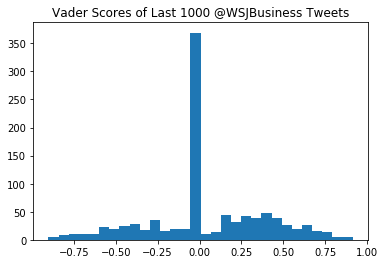

In [20]:
analyzer = SentimentIntensityAnalyzer()
vs = []
for tweet in text:
    vs.append(analyzer.polarity_scores(tweet)['compound'])
plt.hist(vs,bins = 30)
plt.title("Vader Scores of Last 1000 @WSJBusiness Tweets")
plt.show()

Done fetching tweets


WSJbusiness Score Summary
count    3198.000000
mean        0.052611
std         0.354198
min        -0.904200
0%         -0.904200
10%        -0.421500
20%        -0.246440
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.202300
80%         0.381800
90%         0.541600
max         0.922900
dtype: float64


Done fetching tweets


nytimesbusiness Score Summary
count    3200.000000
mean        0.035600
std         0.359084
min        -0.906200
0%         -0.906200
10%        -0.475440
20%        -0.273200
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.202300
80%         0.381800
90%         0.510600
max         0.921700
dtype: float64


Done fetching tweets


FoxBusiness Score Summary
count    3200.000000
mean       -0.029825
std         0.343470
min        -0.920100
0%         -0.920100
10%        -0.526700
20%        -0.340000
30%        -0.102700
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.226300
90%         0.421500
max         0.926000
dtype: float64


Done fetching tweets


nprbusiness Score Summary
count    3200.000000
mean       -0.018390
std         0.353298
min        -0.951700
0%         -0.951700
10%        -0.493900
20%        -0.340000
30%        -0.119180
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.025800
80%         0.296000
90%         0.458800
max         0.950700
dtype: float64


Done fetching tweets


reutersbiz Score Summary
count    3200.000000
mean        0.073215
std         0.325603
min        -0.855500
0%         -0.855500
10%        -0.361200
20%        -0.144900
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.250000
80%         0.381800
90%         0.524880
max         0.883400
dtype: float64


Done fetching tweets


business Score Summary
count    3200.000000
mean        0.046309
std         0.357538
min        -0.904200
0%         -0.904200
10%        -0.458800
20%        -0.250000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.226300
80%         0.381800
90%         0.526700
max         0.908100
dtype: float64


Done fetching tweets


ft Score Summary
count    3200.000000
mean       -0.023602
std         0.341205
min        -0.946000
0%         -0.946000
10%        -0.510600
20%        -0.340000
30%        -0.102700
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.273200
90%         0.440400
max         0.883400
dtype: float64


Done fetching tweets


barronsonline Score Summary
count    3200.000000
mean        0.104755
std         0.331801
min        -0.933700
0%         -0.933700
10%        -0.340000
20%        -0.051600
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.128000
70%         0.296000
80%         0.401900
90%         0.557400
max         0.904200
dtype: float64


Done fetching tweets


cnbc Score Summary
count    3200.000000
mean        0.078196
std         0.333066
min        -0.931300
0%         -0.931300
10%        -0.361200
20%        -0.025800
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.226300
80%         0.393580
90%         0.542300
max         0.944200
dtype: float64


Done fetching tweets


markets Score Summary
count    3200.000000
mean        0.035207
std         0.352420
min        -0.920100
0%         -0.920100
10%        -0.458800
20%        -0.273200
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.202300
80%         0.361200
90%         0.493900
max         0.934900
dtype: float64


Done fetching tweets


economics Score Summary
count    3200.000000
mean        0.029347
std         0.356354
min        -0.920100
0%         -0.920100
10%        -0.476700
20%        -0.273200
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.202300
80%         0.361200
90%         0.493900
max         0.889500
dtype: float64


Done fetching tweets


MarketWatch Score Summary
count    3200.000000
mean        0.060355
std         0.359467
min        -0.940300
0%         -0.940300
10%        -0.440400
20%        -0.226300
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.250000
80%         0.401900
90%         0.542300
max         0.921700
dtype: float64


Done fetching tweets


WSJmarkets Score Summary
count    3200.000000
mean        0.076393
std         0.336313
min        -0.919700
0%         -0.919700
10%        -0.381800
20%        -0.134460
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.043860
70%         0.273200
80%         0.381800
90%         0.526700
max         0.944600
dtype: float64


Done fetching tweets


WSJecon Score Summary
count    3200.000000
mean        0.031099
std         0.333137
min        -0.888500
0%         -0.888500
10%        -0.401900
20%        -0.250000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.177900
80%         0.353840
90%         0.460590
max         0.839900
dtype: float64


Done fetching tweets


BW Score Summary
count    3200.000000
mean        0.082908
std         0.354677
min        -0.894500
0%         -0.894500
10%        -0.383200
20%        -0.102700
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.025800
70%         0.250000
80%         0.405820
90%         0.584900
max         0.953800
dtype: float64


Done fetching tweets


WashingtonPost Score Summary
count    3200.000000
mean       -0.050988
std         0.398731
min        -0.949300
0%         -0.949300
10%        -0.624900
20%        -0.421500
30%        -0.273200
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.315000
90%         0.502300
max         0.897900
dtype: float64


Done fetching tweets


BloombergTV Score Summary
count    3200.000000
mean        0.092419
std         0.345233
min        -0.918600
0%         -0.918600
10%        -0.381800
20%        -0.077200
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.077200
70%         0.292400
80%         0.401900
90%         0.582820
max         0.927400
dtype: float64


Done fetching tweets


CNNBusiness Score Summary
count    3200.000000
mean        0.044616
std         0.356775
min        -0.931300
0%         -0.931300
10%        -0.476700
20%        -0.273200
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.226300
80%         0.381800
90%         0.510600
max         0.898600
dtype: float64


Done fetching tweets


politico Score Summary
count    3200.000000
mean       -0.000800
std         0.346965
min        -0.900100
0%         -0.900100
10%        -0.502530
20%        -0.296000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.113900
80%         0.296000
90%         0.458800
max         0.923100
dtype: float64


Done fetching tweets


federalreserve Score Summary
count    3200.000000
mean        0.093931
std         0.257660
min        -0.855500
0%         -0.855500
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.381800
90%         0.476700
max         0.875000
dtype: float64


Done fetching tweets
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


NASDAQ Score Summary
count    3200.000000
mean        0.260126
std         0.319674
min        -0.784500
0%         -0.784500
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.250000
60%         0.381800
70%         0.492600
80%         0.571900
90%         0.709600
max         0.932500
dtype: float64


Done fetching tweets


BusinessInsider Score Summary
count    3199.000000
mean        0.048963
std         0.350170
min        -0.921700
0%         -0.921700
10%        -0.458800
20%        -0.177900
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.202300
80%         0.381800
90%         0.524720
max         0.955900
dtype: float64


Done fetching tweets


AP Score Summary
count    3200.000000
mean       -0.019887
std         0.431213
min        -0.952400
0%         -0.952400
10%        -0.648600
20%        -0.440400
30%        -0.250000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.202300
80%         0.401900
90%         0.571900
max         0.909800
dtype: float64


Done fetching tweets


thehill Score Summary
count    3200.000000
mean       -0.069682
std         0.368688
min        -0.923100
0%         -0.923100
10%        -0.585900
20%        -0.440400
30%        -0.273200
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.182780
90%         0.440400
max         0.913600
dtype: float64


Done fetching tweets


Forbes Score Summary
count    3200.000000
mean        0.116554
std         0.350955
min        -0.923100
0%         -0.923100
10%        -0.361200
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.128000
70%         0.381800
80%         0.458800
90%         0.571900
max         0.936000
dtype: float64


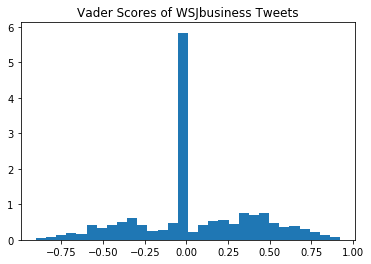

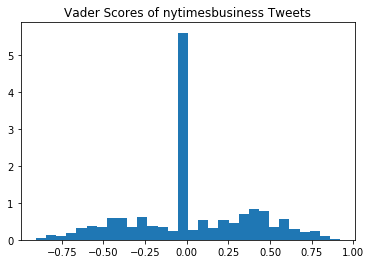

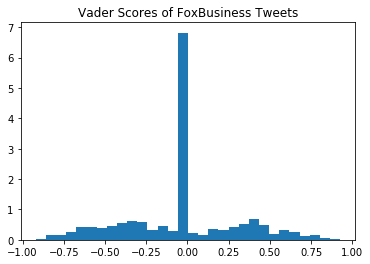

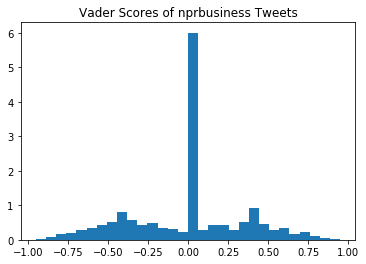

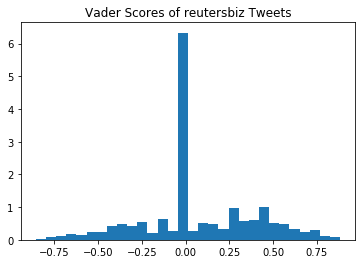

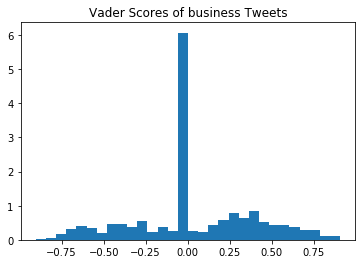

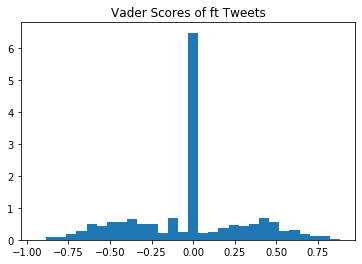

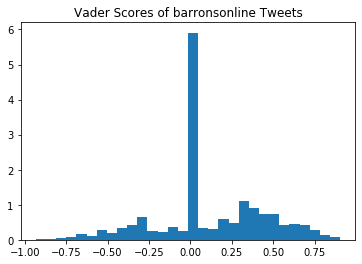

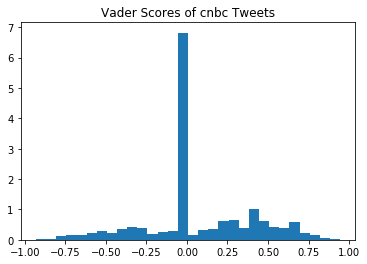

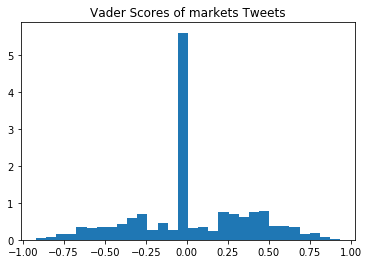

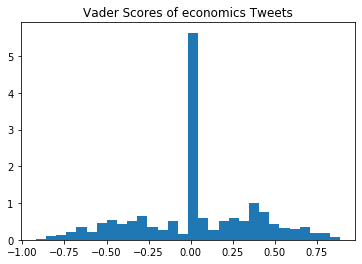

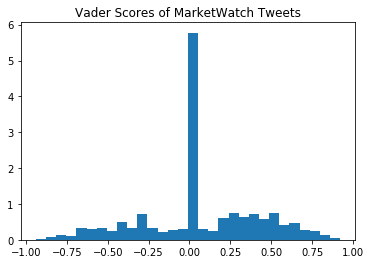

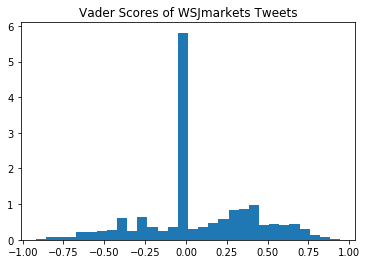

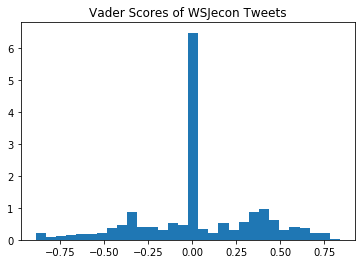

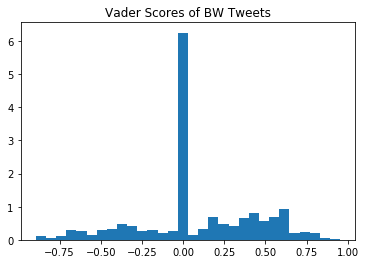

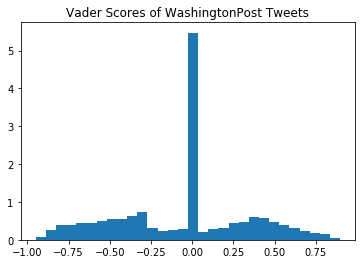

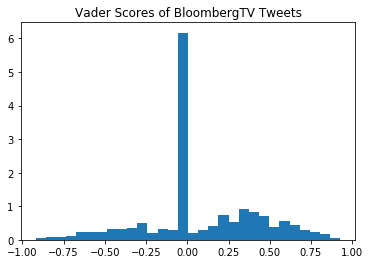

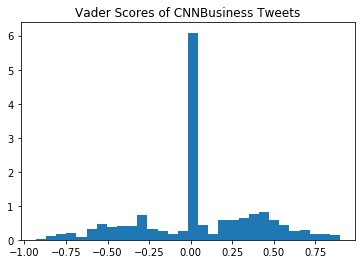

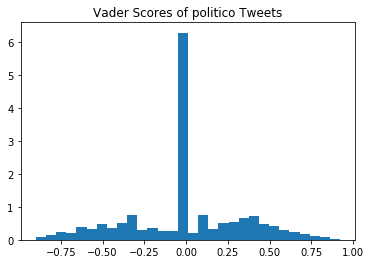

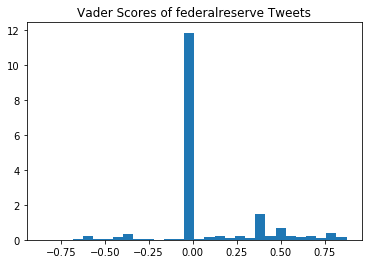

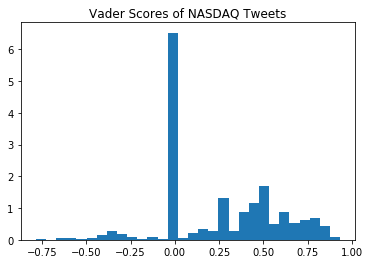

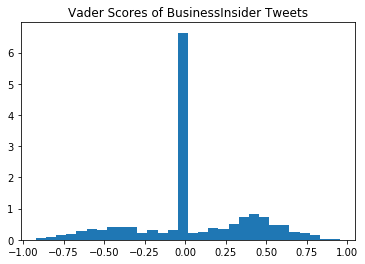

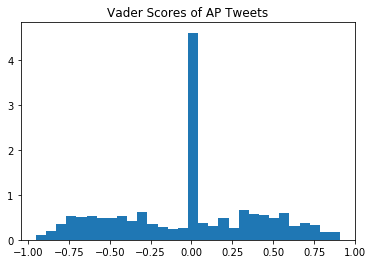

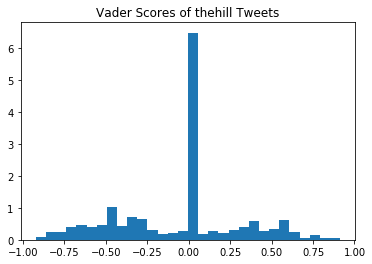

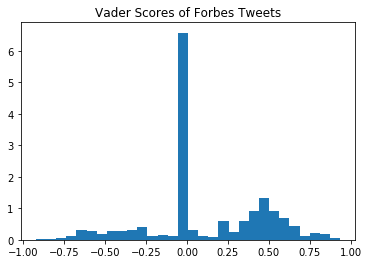

25

In [245]:
handles = ["WSJbusiness","nytimesbusiness","FoxBusiness","nprbusiness","reutersbiz","business",
           "ft","barronsonline","cnbc","markets","economics","MarketWatch","WSJmarkets","WSJecon",
          "BW","WashingtonPost","BloombergTV","CNNBusiness","politico","federalreserve",
          "NASDAQ","BusinessInsider","AP","thehill","Forbes"]
tfh = {}
for user in handles:
    tfh[user] = harvest_user_timeline(twitter_api, screen_name=user, max_results=25000)
    analyzer = SentimentIntensityAnalyzer()
    for tw in tfh[user]:
        txt = tw["text"].split()
        tw["score"] = analyzer.polarity_scores(tw["text"])['compound']
    vaderScores = [x["score"] for x in tfh[user] if x["score"] > -2]
    plt.figure(handles.index(user))
    plt.hist(vaderScores,bins = 30,density=True)
    plt.title("Vader Scores of "+ user + " Tweets")
    print(user + " Score Summary")
    print(pd.Series(vaderScores).describe(percentiles=[0.1*x for x in range(10)]))
plt.show()
len(handles)

In [246]:
daily_sentiment = {}
for i in range(min(list(len(tfh[u]) for u in handles))):
    for user in handles:
        daily_sentiment[tfh[user][i]["created_at"][4:10] + " " + tfh[user][i]["created_at"][-4:]] = 0
sizes = {d:0 for d in list(daily_sentiment.keys())}
for user in handles:
    for t in tfh[user]:
        date = t["created_at"][4:10] + " " + t["created_at"][-4:]
        if t["score"] > -2:
            try:
                sizes[date] += 1
                daily_sentiment[date] += t["score"]
            except:
                sizes[date] = 0
                sizes[date] += 1
                daily_sentiment[date] = 0
                daily_sentiment[date] += t["score"]
for d in list(daily_sentiment.keys()):
    if sizes[d] > 0:
        daily_sentiment[d] /= sizes[d]
daily_sentiment

{'Nov 04 2021': 0.03663413968006229,
 'Nov 07 2021': 0.03234577777777778,
 'Nov 06 2021': 0.011908920187793427,
 'Oct 14 2021': 0.014237819420783664,
 'Nov 05 2021': 0.038178595744680716,
 'Nov 01 2021': 0.045084383088869646,
 'Sep 22 2021': 0.06305448430493268,
 'Oct 27 2021': 0.0831539188438021,
 'Oct 20 2021': 0.021059461805555582,
 'Sep 21 2021': 0.02533562340966921,
 'Oct 18 2021': 0.028485952848722993,
 'Oct 16 2021': 0.030505477031802168,
 'Oct 08 2021': 0.06130649350649353,
 'Oct 05 2021': 0.034506804374240585,
 'Sep 28 2021': 0.014790356083086027,
 'Sep 13 2021': 0.04723457249070632,
 'Nov 03 2021': 0.04651869021339215,
 'Sep 20 2021': 0.002671428571428588,
 'Sep 02 2021': -0.002183713355048848,
 'Aug 26 2021': -0.0026638297872340353,
 'Aug 25 2021': 0.05093217665615141,
 'Nov 02 2021': 0.04373263969171468,
 'Aug 24 2021': 0.041301030927835054,
 'Aug 06 2021': 0.058110034602076116,
 'Aug 05 2021': 0.047154220779220775,
 'Jul 29 2021': 0.07134881355932202,
 'Oct 29 2021': 0.057

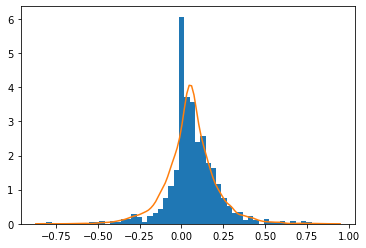

In [252]:
plt.hist(list(daily_sentiment.values()),density = True, bins = 50)
sns.kdeplot(np.random.laplace(pd.Series(list(daily_sentiment.values())).median(),pd.Series(list(daily_sentiment.values())).mad(),size=10**4))

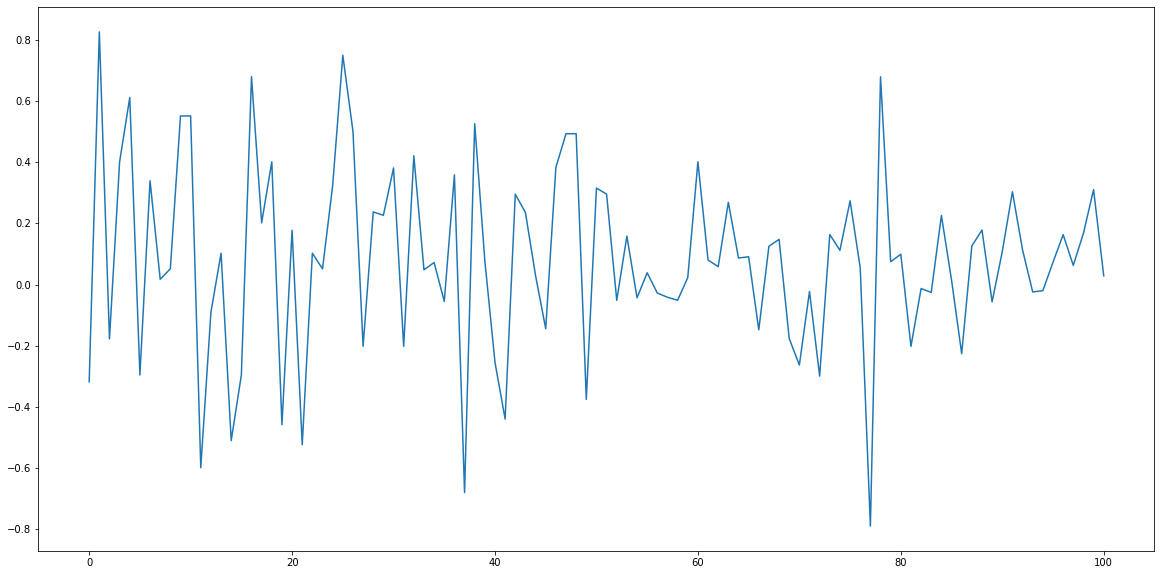

In [223]:
plt.figure(figsize = (20,10))
plt.plot(list(reversed(list(daily_sentiment.values()))))
plt.show()

In [110]:
list(daily_sentiment.keys())[0], list(daily_sentiment.keys())[-1]

('Nov 04 2021', 'Jan 17 2018')

In [111]:
t["created_at"][:10] + " " + t["created_at"][-4:]

'Sat Oct 23 2021'

In [177]:
tslareturns = pd.read_csv("TSLA.csv")
spyreturns = pd.read_csv("SPY-7.csv")
TSLA_returns = tslareturns["Adj Close"].pct_change()[1:]
SPY_returns = spyreturns["Adj Close"].pct_change()[1:]
rar = TSLA_returns - SPY_returns
tslareturns["RAR"] = rar

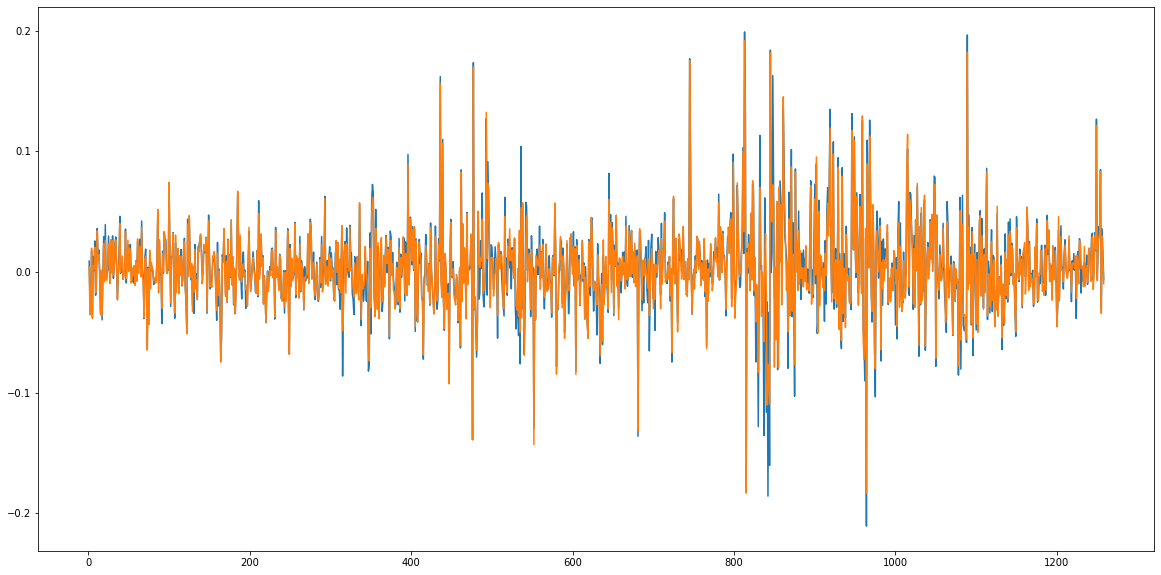

In [178]:
plt.figure(figsize = (20,10))
plt.plot(TSLA_returns)
plt.plot(rar)
plt.show()

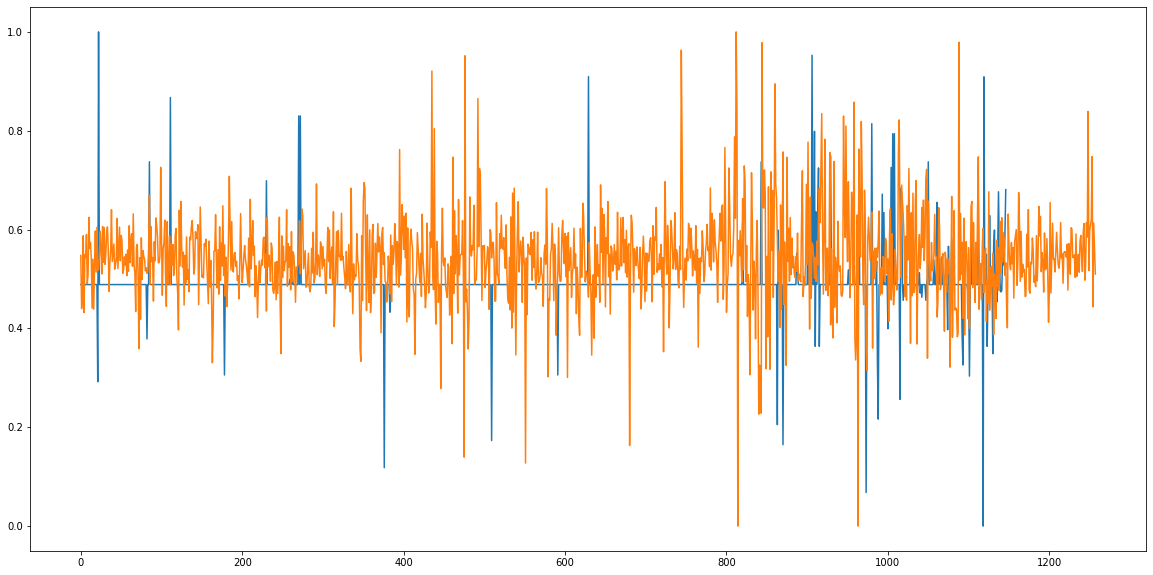

In [179]:
plt.figure(figsize = (20,10))
plt.plot(norm(list(reversed(list(daily_sentiment.values())))[:-1]))
plt.plot(norm(np.log(1+rar)))
plt.show()

In [180]:
len(daily_returns), len(list(reversed(list(daily_sentiment.values())))[:-1])

(1258, 1147)

In [181]:
modded_dates = []
months = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
for d in tslareturns["Date"]:
    modded_dates.append(months[int(d[5:7])]+" "+d[-2:]+" "+d[:4])
df = pd.DataFrame()
df["Date"] = modded_dates
df["Return"] = rar

In [182]:
sent = []
for i in range(len(df)):
    if df["Date"][i] not in list(daily_sentiment.keys()):
        df.drop(i,axis=0,inplace=True)
    else:
        sent.append(daily_sentiment[df["Date"][i]])
df["Sentiment"] = sent

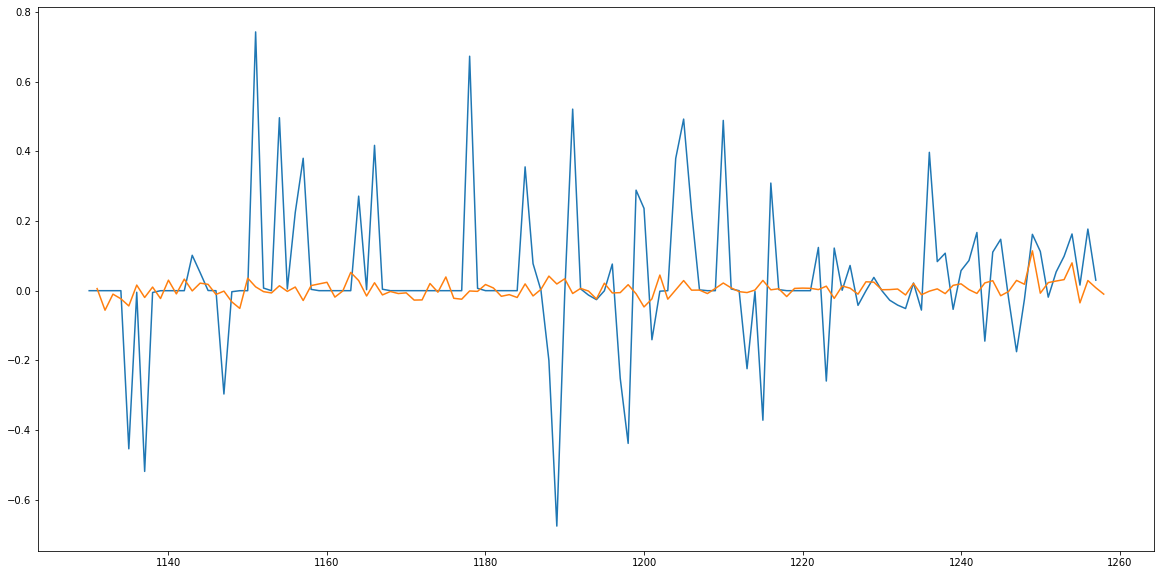

In [209]:
a=.99
plt.figure(figsize = (20,10))
plt.plot(df["Sentiment"][807:len(df)-1].ewm(alpha=a,adjust=False).mean())
plt.plot(np.log(1+df["Return"][808:]))
plt.show()

In [210]:
st.spearmanr(df["Sentiment"][807:len(df)-1].ewm(alpha=a).mean(), np.log(1+df["Return"][808:]))[0]

-0.11059989589470165

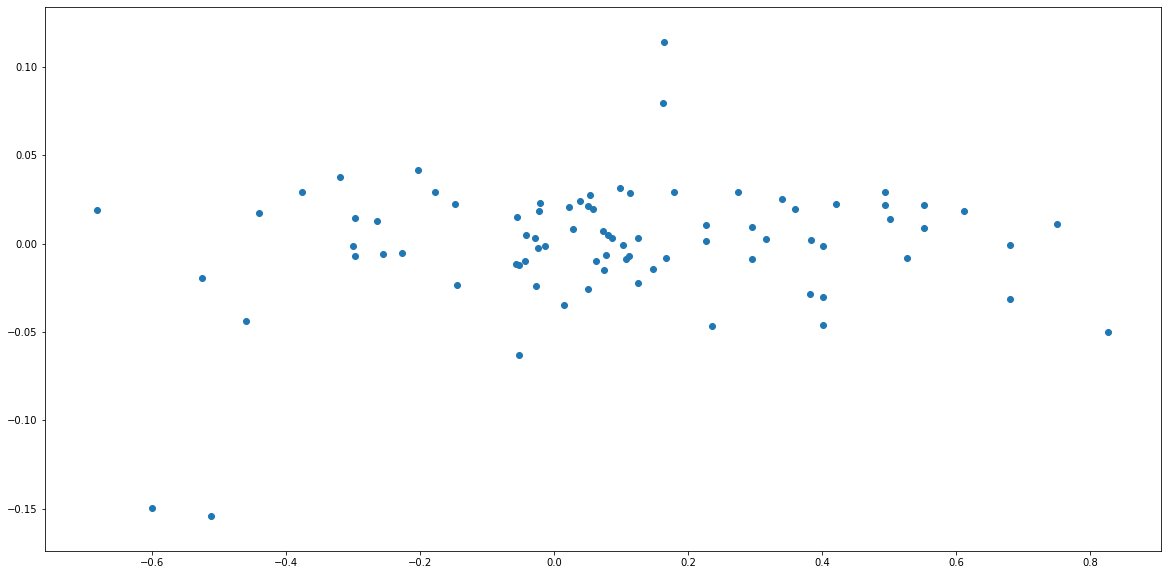

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [237]:
plt.figure(figsize = (20,10))
nzdf = df.loc[df["Sentiment"] != 0]
plt.scatter(nzdf.Sentiment,np.log(1+nzdf.Return))
plt.show()
st.pearsonr(nzdf["Sentiment"],nzdf["Return"])[0]
nzdf["Year"] = [int(x[-4:]) for x in nzdf["Date"]]

Window 1 Pearson and Spearman Correlation vs Exponentially Weighted MA Alpha


<Figure size 432x288 with 0 Axes>

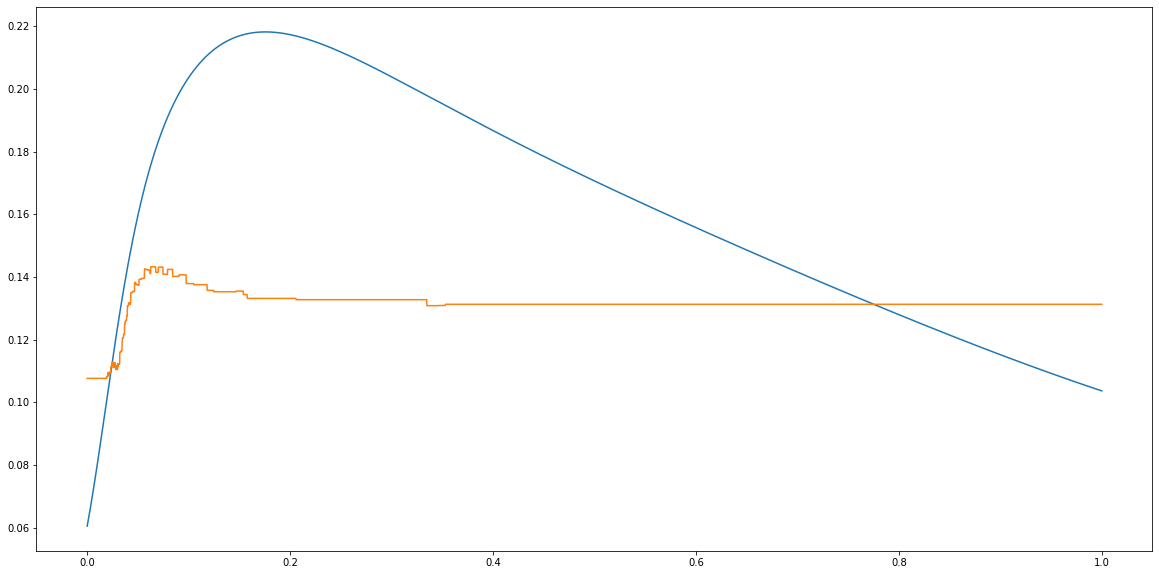

Window 2 Pearson and Spearman Correlation vs Exponentially Weighted MA Alpha


<Figure size 432x288 with 0 Axes>

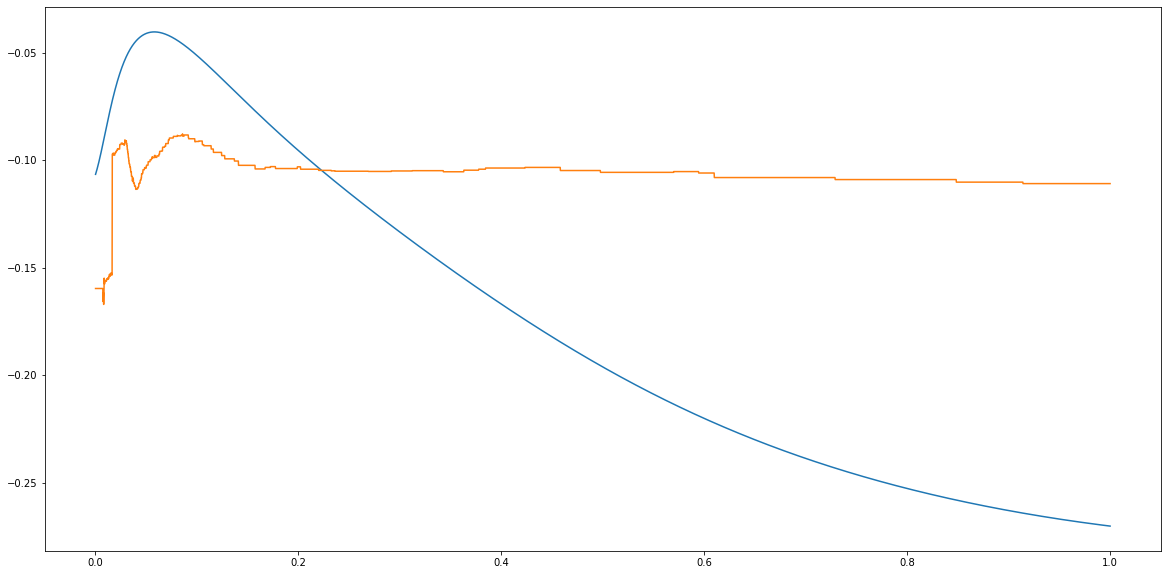

Window 3 Pearson and Spearman Correlation vs Exponentially Weighted MA Alpha


<Figure size 432x288 with 0 Axes>

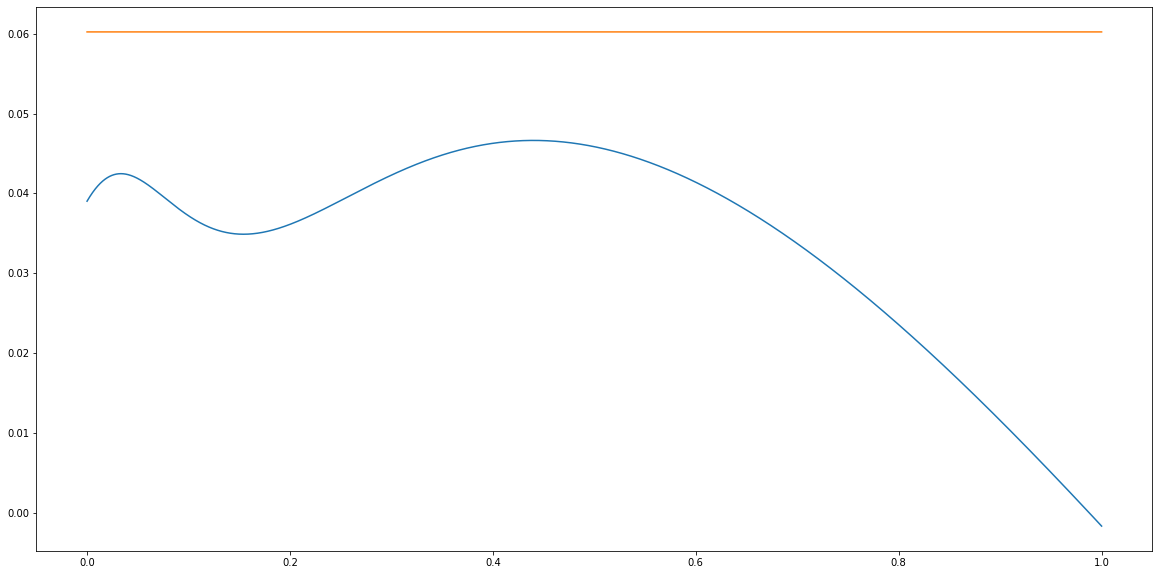

Window 4 Pearson and Spearman Correlation vs Exponentially Weighted MA Alpha


<Figure size 432x288 with 0 Axes>

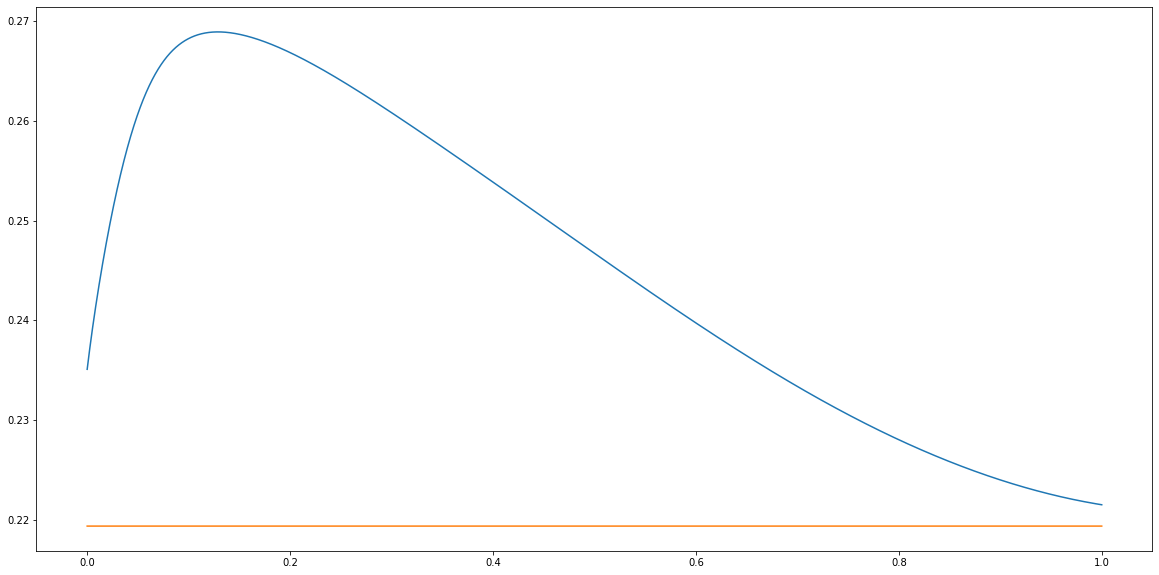

Window 5 Pearson and Spearman Correlation vs Exponentially Weighted MA Alpha


<Figure size 432x288 with 0 Axes>

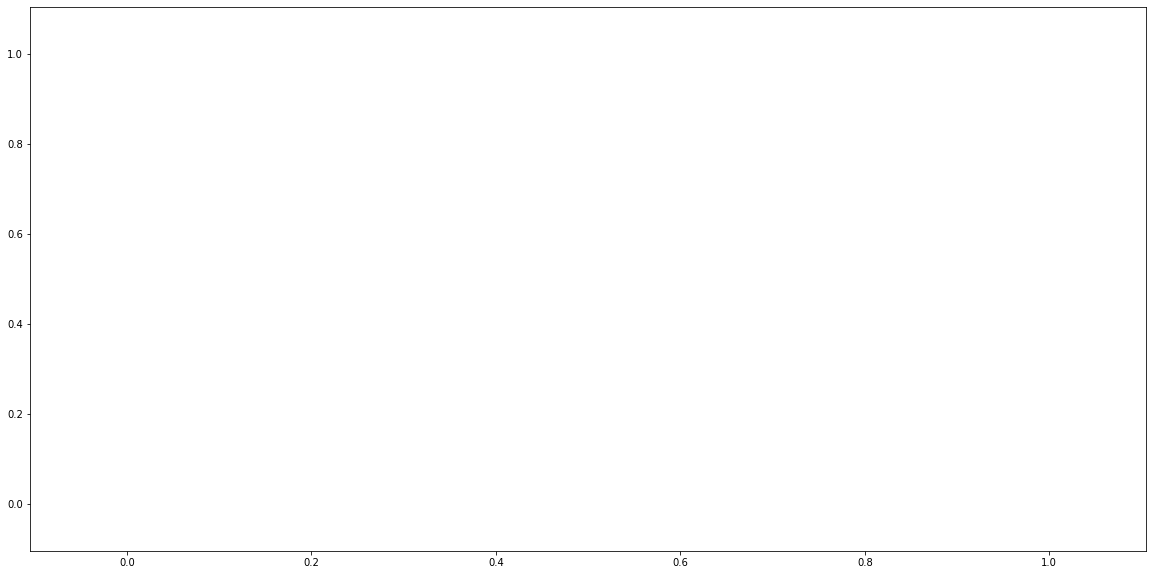

KeyboardInterrupt: 

In [214]:
lower = 0
upper = 90
k = 1
f = 10**4
maxsprk = []
maxlin = []
while upper < len(df):
    sprk=[]
    lcorr = []
    for a in range(1, f):
        lcorr.append(st.pearsonr(df["Return"][lower+1:upper],df["Sentiment"][lower:upper-1].ewm(adjust=False,alpha = a/f).mean().dropna())[0])
        sprk.append(st.spearmanr(df["Return"][lower+1:upper],df["Sentiment"][lower:upper-1].ewm(adjust=False,alpha = a/f).mean().dropna())[0])
    maxsprk.append(max(sprk))
    maxlin.append(max(lcorr))
    print("Window",k,"Pearson and Spearman Correlation vs Exponentially Weighted MA Alpha")
    plt.figure(k)
    plt.figure(figsize = (20,10))
    plt.plot([a / f for a in range(1,f)], lcorr)
    plt.plot([a / f for a in range(1,f)], sprk)
    plt.show()
    lower += 90
    upper += 90
    k+=1

In [ ]:
max(maxlin), max(maxsprk)

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(maxsprk,label="Max Spearman Rank Correlation Over Time")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(maxlin,label="Max Linear Correlation over Time")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
plt.hist(maxlin,density=True,bins=50,label = "Max Monthly Spearman Rank Correlation",alpha=0.5)
plt.hist(maxsprk,density=True,bins=50,label="Max Monthly Linear Correlation",alpha=0.5)
plt.legend()
plt.show()

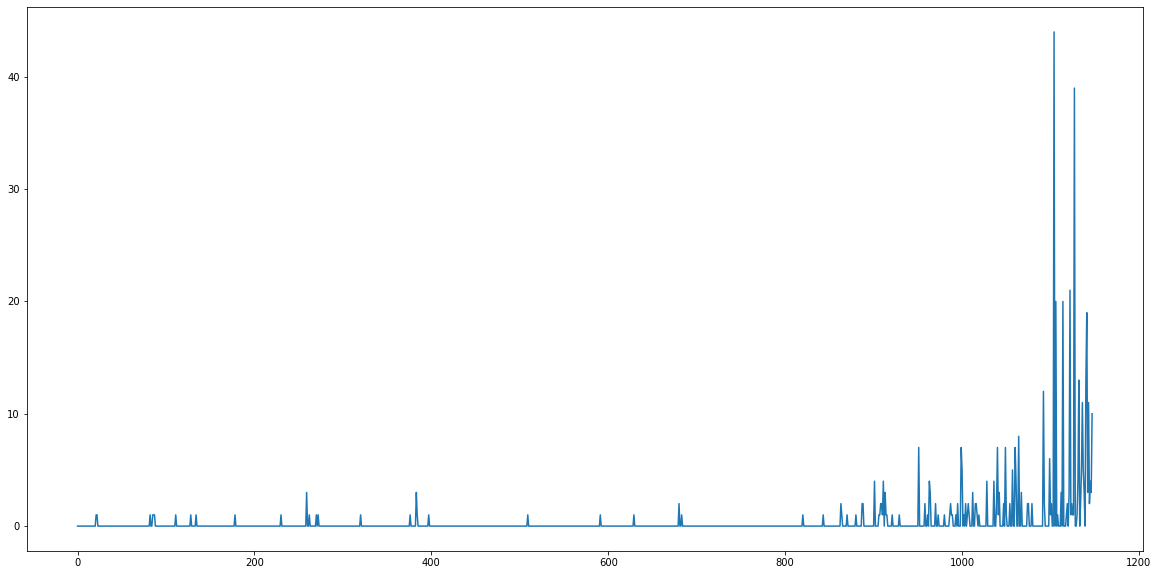

{'Nov 04 2021': 10,
 'Nov 06 2021': 3,
 'Oct 14 2021': 4,
 'Nov 05 2021': 2,
 'Nov 01 2021': 11,
 'Sep 22 2021': 3,
 'Oct 27 2021': 19,
 'Oct 20 2021': 13,
 'Sep 21 2021': 0,
 'Oct 18 2021': 3,
 'Oct 16 2021': 5,
 'Oct 08 2021': 11,
 'Oct 05 2021': 5,
 'Sep 28 2021': 2,
 'Sep 13 2021': 0,
 'Nov 03 2021': 13,
 'Sep 20 2021': 4,
 'Sep 02 2021': 1,
 'Aug 26 2021': 0,
 'Aug 25 2021': 0,
 'Nov 02 2021': 39,
 'Aug 24 2021': 1,
 'Aug 06 2021': 1,
 'Aug 05 2021': 2,
 'Jul 29 2021': 1,
 'Oct 29 2021': 21,
 'Jul 27 2021': 3,
 'Jul 21 2021': 0,
 'Jul 15 2021': 2,
 'Sep 19 2021': 1,
 'Jul 13 2021': 0,
 'Jul 08 2021': 0,
 'Jul 06 2021': 0,
 'Oct 28 2021': 20,
 'Jul 02 2021': 0,
 'Jun 24 2021': 3,
 'Jun 22 2021': 0,
 'Jun 21 2021': 0,
 'Jun 18 2021': 0,
 'Sep 18 2021': 1,
 'Jun 16 2021': 0,
 'Oct 26 2021': 20,
 'Jun 09 2021': 0,
 'Oct 25 2021': 44,
 'Jun 04 2021': 0,
 'Jun 03 2021': 0,
 'Jun 01 2021': 2,
 'May 28 2021': 1,
 'Oct 22 2021': 6,
 'May 20 2021': 0,
 'May 18 2021': 0,
 'May 16 2021': 0,
 

In [221]:
plt.figure(figsize = (20,10))
plt.plot(list(reversed(list(sizes.values()))))
plt.show()
sizes

## PPI Data

In [40]:
ppi = pd.read_csv("PPIACO.csv")
ppi.loc[ppi.DATE == '2017-12-01']
ppi = ppi[1259:]
ppi.head()

,DATE,PPIACO
1259,2017-12-01,196.3
1260,2018-01-01,197.9
1261,2018-02-01,199.3
1262,2018-03-01,199.3
1263,2018-04-01,200.3


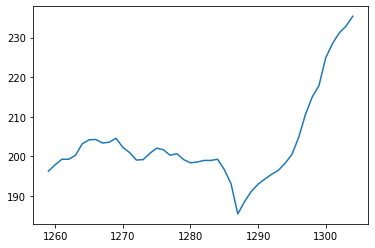

In [41]:
plt.plot(ppi.PPIACO)

In [42]:
tsa.acf(ppi.PPIACO)

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([ 1.        ,  0.87751742,  0.73830589,  0.58696347,  0.43332745,
        0.28366857,  0.16369843,  0.0484301 , -0.05342274, -0.13299069,
       -0.19054569, -0.23262032, -0.26065507, -0.27810418, -0.28085281,
       -0.27171124, -0.24797869, -0.20454908, -0.1376846 , -0.10862236,
       -0.09568782, -0.09747268, -0.09361886, -0.08554518, -0.06942411,
       -0.04968787, -0.03209213, -0.02312465, -0.01340055, -0.02067   ,
       -0.02604312, -0.01910957, -0.00186222,  0.01518202,  0.01939785,
        0.01368449, -0.00819736, -0.02893755, -0.04914809, -0.07162594,
       -0.0924384 ])

0.013468164911405726

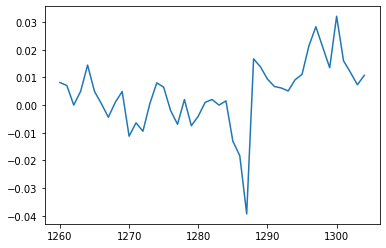

In [43]:
plt.plot(ppi.PPIACO.pct_change()[1:])
tsa.adfuller(ppi.PPIACO.diff()[1:])[1]

In [44]:
## Constructing an interpolated time series for PPI
ppiits = []
dateits = []
monlen = {'01':31,'02':28,'03':31,'04':30,'05':31,'06':30,'07':31,'08':31,'09':30,'10':31,'11':30,'12':31}
for i in range(min(ppi.index), max(ppi.index) - 1):
    dateits.append(ppi.DATE[i])
    date = datetime.date.fromisoformat(ppi.DATE[i])
    ppiits.append(ppi.PPIACO[i])
    St = ppi.PPIACO[i]
    for k in range(monlen[ppi.DATE[i][5:7]]-1):
        #St += (ppi.PPIACO[i+1] - ppi.PPIACO[i]) / monlen[ppi.DATE[i][5:7]]
        ppiits.append(St)
        date = date.replace(day = date.day+1) 
        dateits.append(datetime.date.isoformat(date))
ppi_interp = pd.DataFrame()
ppi_interp["Date"] = dateits
ppi_interp["PPI"] = ppiits

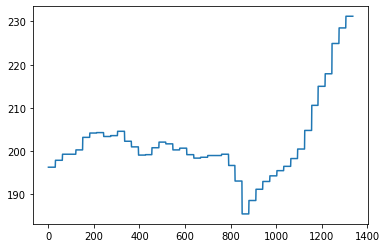

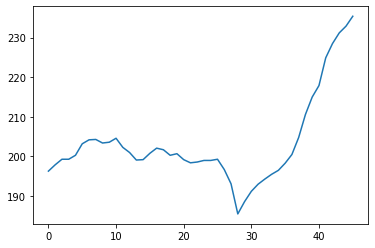

In [45]:
plt.figure(0)
plt.plot(pd.Series(ppi_interp["PPI"]))
plt.figure(1)
plt.plot(ppi.PPIACO.reset_index(drop=True))

In [46]:
len(ppiits), len(df["Return"])

(1338, 919)

In [47]:
months_inv = {"Jan":"01","Feb":"02","Mar":"03","Apr":"04","May":"05","Jun":"06","Jul":"07",
             "Aug":"08","Sep":"09","Oct":"10","Nov":"11","Dec":"12"}
df.reset_index(drop=True,inplace=True)
upDate = []
for i in range(len(df)):
    upDate.append(df.Date[i][7:] + "-" + months_inv[df.Date[i][0:3]] + "-" + df.Date[i][4:6])
upDate
df.Date = upDate

In [48]:
mdf = df[["Date","Sentiment","Return"]][1:].merge(right = ppi_interp,on = ["Date"])
mdf

,Date,Sentiment,Return,PPI
0,2018-02-02,0.121235,-0.021770,199.3
1,2018-02-05,-0.025752,-0.041823,199.3
2,2018-02-06,0.179415,0.019702,199.3
3,2018-02-07,0.210871,-0.005425,199.3
4,2018-02-08,0.086600,-0.037509,199.3
...,...,...,...,...
852,2021-07-26,0.071139,0.002455,231.2
853,2021-07-27,0.066444,-0.004558,231.2
854,2021-07-28,0.111115,-0.000410,231.2
855,2021-07-29,0.071349,0.004147,231.2


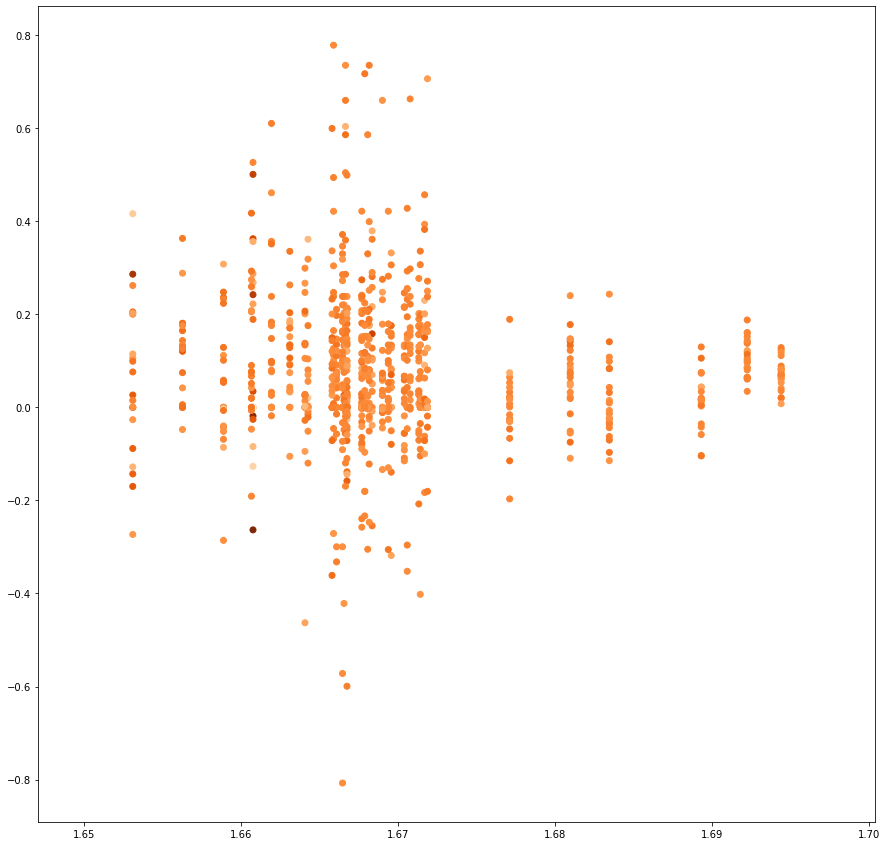

In [49]:
plt.figure(figsize = (15,15))
plt.scatter(np.log(np.log(mdf["PPI"])), mdf["Sentiment"],c = mdf["Return"],cmap="Oranges")
plt.show()

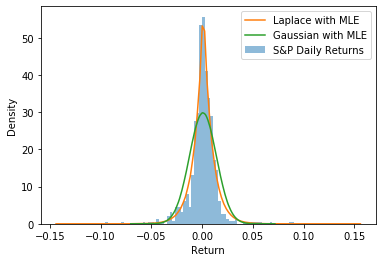

In [50]:
plt.hist(mdf["Return"],density=True,bins=70,alpha=0.5,label="S&P Daily Returns")
sns.kdeplot(np.random.laplace(mdf.Return.median(),mdf.Return.mad(),size=10**7),label="Laplace with MLE")
sns.kdeplot(np.random.normal(mdf.Return.mean(),mdf.Return.std(),size=10**7),label="Gaussian with MLE")
plt.legend()
plt.ylabel("Density")
plt.xlabel("Return")
plt.show()

In [51]:
T = 100
test_size = 100
train = df["Return"][1:][:len(df)-test_size-1].reset_index(drop=True)
test = df["Return"][1:][len(df)-test_size-1:].reset_index(drop=True)
K = int(np.ceil(np.sqrt(len(df)-test_size)))
r = df["Return"][1:][len(df) - test_size + 1]
R = {k:[r] for k in range(30)}
neigh = KNeighborsRegressor(n_neighbors=K)
neigh.fit(np.array(train).reshape(-1,1),train)
for t in range(T-1):
    for j in range(30):
        median = pd.Series(neigh.kneighbors(np.array(R[j][-1]).reshape(1,-1),K)[0][0]).median()
        scale = pd.Series(neigh.kneighbors(np.array(R[j][-1]).reshape(1,-1),K)[0][0]).mad()
        r = np.random.laplace(median,12.5*scale)
        R[j].append(r)

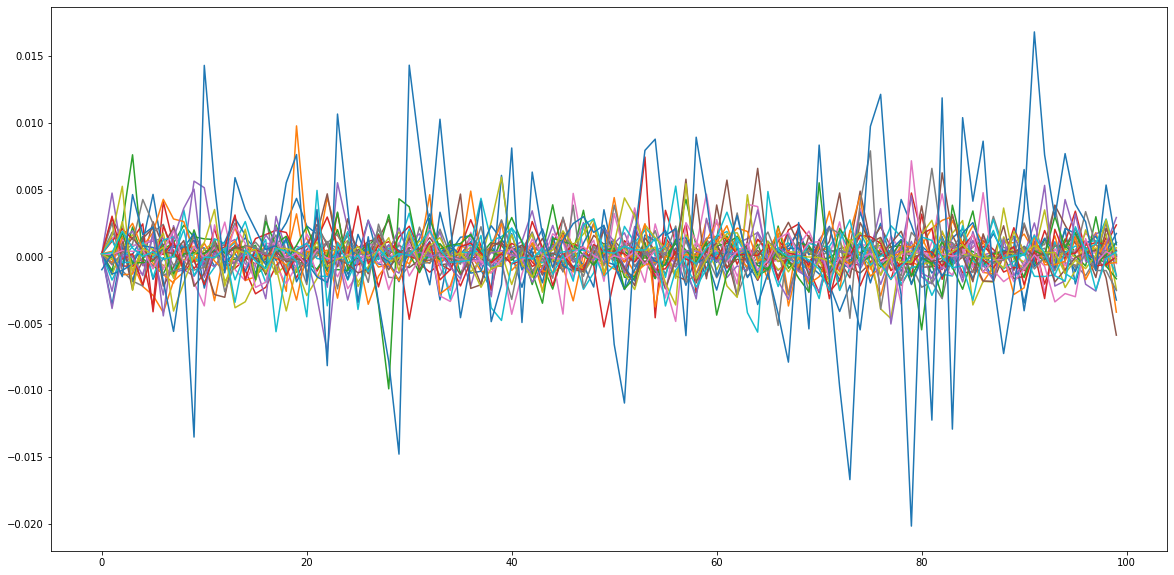

In [52]:
plt.figure(figsize = (20,10))
for i in range(30):
    plt.plot(R[i])
plt.plot(test)
plt.show()

## HMM Up/Down Signal

In [54]:
np.random.seed(123)

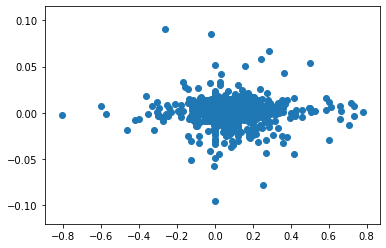

In [254]:
plt.scatter(mdf["Sentiment"],mdf["Return"])

In [268]:
from sklearn.cluster import KMeans
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=20)
scaled_features = pd.DataFrame()
scaled_features["Sentiment"] = (mdf["Sentiment"] - mdf["Sentiment"].mean()) / mdf["Sentiment"].std()
scaled_features["Return"] = (mdf["Return"] - mdf["Return"].mean()) / mdf["Return"].std()
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=20)

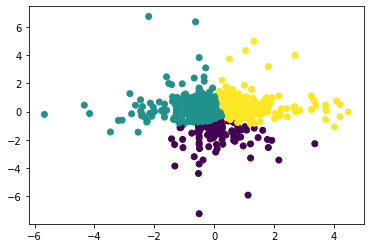

,Sentiment,Return
0,0.274641,-1.692137
1,-0.666672,-3.194053
2,0.647228,1.414041
3,0.848673,-0.467936
4,0.052838,-2.870960


In [270]:
plt.scatter(scaled_features["Sentiment"],scaled_features["Return"],c = kmeans.labels_,cmap = 'viridis')
plt.show()
scaled_features.head()

In [380]:
#N = 5
model = hmm.GaussianHMM(n_components=2, covariance_type="full",algorithm='map').fit(scaled_features)
#model.startprob_ = np.array([0.6, 0.3, 0.1])
#model.transmat_ = np.array([[1/N for x in range(N)] for y in range(N)])
#model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
#model.covars_ = 
#X, Z = model.sample(100)
model.predict(scaled_features)

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [381]:
print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

Transition matrix
[[0.84476033 0.15523967]
 [0.4460017  0.5539983 ]]

Means and vars of each hidden state
0th hidden state
mean =  [-0.08772572  0.07721376]
var =  [0.38637853 0.26614634]

1th hidden state
mean =  [ 0.24992924 -0.21998084]
var =  [2.65940702 3.02095944]



In [382]:
scaled_features.describe()

,Sentiment,Return
count,8.570000e+02,8.570000e+02
mean,6.227678e-16,-2.338334e-17
std,1.000000e+00,1.000000e+00
min,-5.672374e+00,-7.227667e+00
25%,-5.017523e-01,-3.486999e-01
50%,-1.028721e-01,3.175455e-02
75%,4.607749e-01,4.630416e-01
max,4.482512e+00,6.724399e+00


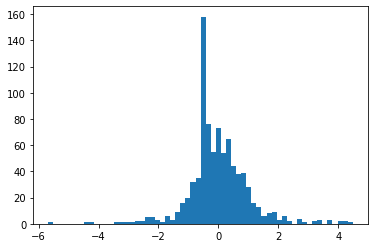

In [383]:
plt.hist(scaled_features['Sentiment'],bins=60)
plt.show()

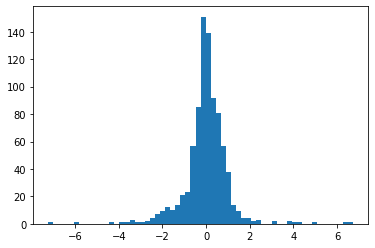

In [384]:
plt.hist(scaled_features['Return'],bins=60)
plt.show()

In [385]:
model.get_stationary_distribution()

array([0.74180142, 0.25819858])

In [386]:
model.sample()[0][0][1]*mdf["Return"].std() + mdf["Return"].mean()

-0.0011911484515540849

In [387]:
model.score_samples(scaled_features)

(-2153.0379738162314, array([[1.72670688e-10, 1.00000000e+00],
        [2.86036236e-08, 9.99999971e-01],
        [1.40970606e-01, 8.59029394e-01],
        ...,
        [9.84808052e-01, 1.51919483e-02],
        [9.86062133e-01, 1.39378671e-02],
        [9.65164226e-01, 3.48357737e-02]]))